In [4]:
import numpy as np
import time
from datetime import datetime,timedelta
import json
import re

In [5]:
data_type = 'test' #train or test

In [6]:
#根据log_index，增量读取log内容
def load_log(file_name, log_index):
    log_value_list = list()
    date_list = list()
    status_list = list()
    try:
        with open(file_name,'rb') as f:
            for index,content in enumerate(f):
                if index == log_index:
                    try:
                        log_data = json.loads(content.decode('utf8'))
                    except Exception as e:
                        print(index,content[:50])
                        print ('json解析错误',e)
                        log_index += 1
                        continue
                        
                    if '@timestamp' in log_data:
                        log_data['@timestamp'] = str(datetime.strptime(log_data['@timestamp'][0:19],'%Y-%m-%dT%H:%M:%S'))
                        log_value_list.append(log_data)
                        date_list.append(log_data['@timestamp'])
                        if log_data['status'] not in status_list:
                            status_list.append(log_data['status'])
                    log_index += 1

    except Exception as e:
        print('其他错误',index,e)
    #将文本内容转化为pandas的dataframe
    #temp_log = pd.DataFrame(log_value_list)
    print(status_list)
    return  log_value_list,log_index

In [7]:
time_step = 60 #每x秒读取一次log文件
time_windows = 120 #秒,时间窗口
ip_dict = dict() #ip与对应操作在矩阵的下标
ip_reserve_list = list() #操作矩阵下标对应的ip
all_matrix = np.empty([0, 6],dtype=int)  #操作矩阵
all_url_list = list()
time_index = '2017-07-10 06:25:08' #记录当前的时间
log_index = 0 #记录读到第几行了
ip_behavior_dict = dict() #记录每个ip每分钟请求的页面url

increment_log_data, log_index = load_log('data/'+data_type+'_access_szy_shunnengnet_com_json.log', 0)

['200', '302', '404', '504', '403', '304', '500']


In [8]:
len(increment_log_data)

32766

In [9]:
#截取url，保留其访问传参方式（POST/GET/PUT/DELETE）,保留url的头与尾
def deal_url(url):
    url_str = url.replace(' HTTP/1.1','')
    if url_str.find(' ') > -1:
        url_type = url_str[0 : url_str.find(' ')+1]
    if url_str.find('/') > -1 and url_str.find('?') > -1:
        url_str = url_type + url_str[url_str.find('/')+1 : url_str.find('?')]
    if url_str.find('/') > -1 and url_str.find(';jsessionid') > -1:
        url_str = url_type + url_str[url_str.find('/')+1 : url_str.find(';jsessionid')]
    if url_str.find('/') > -1 and url_str.rfind('/') > -1:
        url_str = url_str[0 : url_str.find('/')] + '/.../' + url_str[url_str.rfind('/')+1 : ]
    return url_str

In [10]:
#根据日志内容，创建一个信息的op_detail
def create_op_detail(row_log):
    op_detail = dict()
    op_detail['sip'] = row_log['sip']
    op_detail['start_time'] = row_log['@timestamp']
    op_detail['end_time'] = row_log['@timestamp']
    op_detail['urls'] = list()
    op_detail['urls'].append(deal_url(row_log['request']))
    return op_detail

In [11]:
#传入开始结束时间的字符串(yyyy-MM-dd HH:mm:ss)，计算时间差并返回时差(秒)
def calc_time_difference(start_time_str, end_time_str):
    start_time = datetime.strptime(start_time_str,'%Y-%m-%d %H:%M:%S')
    end_time = datetime.strptime(end_time_str,'%Y-%m-%d %H:%M:%S')
    return int((end_time - start_time).seconds)

In [12]:
#读取log，生成携带用户行为的复合型字典
def create_user_behavior_dict(increment_log_data, user_behavior_dict):
    
    for x in increment_log_data:
        if x['sip'] != '':
            
            if x['sip'] not in user_behavior_dict.keys():
                user_behavior_dict[x['sip']] = list()

            length = len(user_behavior_dict[x['sip']])
            if length > 0: #opreation内已存在op_detail，此时需要循环该list的所有dict，比较时间差，如果两者时间相差<120s，更新结束时间，添加url；否则继续遍历比较直至找不到合适的区间为止，若找不到合适区间，新建
                new_opreation = 1
                i = 0
                for op_detail in user_behavior_dict[x['sip']]:
                    time_difference = calc_time_difference(op_detail['end_time'], x['@timestamp'])
                    
                    if time_difference < 120:
                        op_detail['end_time'] = x['@timestamp']
                        op_detail['urls'].append(deal_url(x['request']))
                        new_opreation = 0
                        break
                    if new_opreation == 1 and i+1 == length:
                        user_behavior_dict[x['sip']].append(create_op_detail(x))
                        break
                    i += 1
            else:
                 user_behavior_dict[x['sip']].append(create_op_detail(x))
                
    return user_behavior_dict

In [13]:
user_behavior_dict = dict()
start_time = datetime.now()
user_behavior_dict = create_user_behavior_dict(increment_log_data, user_behavior_dict)
end_time = datetime.now()
print((end_time - start_time).seconds)

5


In [14]:
#根据用户行为字典，计算每个活跃时间内每秒钟访问的url次数
visit_dict = dict()
for ip in user_behavior_dict:
    if ip not in visit_dict.keys():
        visit_dict[ip] = list()
    for item_dict in user_behavior_dict[ip]:
        time_difference = calc_time_difference(item_dict['start_time'], item_dict['end_time']) + 8.83 #事实上就算是一组的话，它也是计算这一组开始的时间和最后一个开始的时间，其实最后一个时间的话确实应该加上这个数字
        result = (time_difference/len(item_dict['urls'])) 
        visit_dict[ip].append(result)

In [15]:
#唯一ip字典  包括该ip访问的所有ip的urls以及占比
unique_dict = dict()
for x in increment_log_data:
    ip = x['sip']
    if ip!='':
        if ip not in unique_dict.keys():
            unique_dict[ip] = dict()
            unique_dict[ip]['coverage'] = 0
            unique_dict[ip]['urls'] = list()
            
        url = deal_url(x['request'])
        unique_dict[ip]['urls'].append(url)
    
for ip in unique_dict.keys():
    unique_list = list()
    for url in unique_dict[ip]['urls']:
        if url not in unique_list:
            unique_list.append(url)
    #print(len(unique_dict[ip]['urls']))
    unique_dict[ip]['coverage'] = len(unique_list) / len(unique_dict[ip]['urls'])

In [16]:
#每个ip对应的属性字典
attribute_dict = dict()
for ip in unique_dict:
    if ip not in attribute_dict.keys():
        attribute_dict[ip] = dict()
    attribute_dict[ip]['coverage'] = unique_dict[ip]['coverage']
    attribute_dict[ip]['operation_freq'] = np.array(visit_dict[ip]).sum()/len(visit_dict[ip])
    attribute_dict[ip]['n_op'] = len(visit_dict[ip])


In [17]:
exception_ips = list()
unkown_ips = list()
ex_ip = list()
#覆盖率<0.15的一定是异常信息，因此将ip push进exception_ips
#覆盖率在0.15到0.2之间的,操作数如果大于5的,有可能是一场信息，因此将ip push进exception_ips
#在任何情况下，操作数如果大于10就是异常信息，
for ip in attribute_dict:
    if ip not in exception_ips:
        if attribute_dict[ip]['coverage'] < 0.1:
            ex_ip.append(ip)
        if attribute_dict[ip]['coverage'] < 0.15:
            exception_ips.append(ip)
        elif attribute_dict[ip]['coverage'] < 0.2 and attribute_dict[ip]['n_op'] > 5:
            unkown_ips.append(ip)
            exception_ips.append(ip)

In [18]:
len(exception_ips)

119

In [19]:
unique_url_list_count = dict() #计算一下每一个url出现的次数，url:count
for x in increment_log_data:
    ip = deal_url(x['request'])
    if ip not in unique_url_list_count:
        unique_url_list_count[ip] = 0
    unique_url_list_count[ip] +=1

#生成访问记录所有url的list，唯一，只有大于20的url才被认为具有普遍性
unique_url_list = [x for x in unique_url_list_count.keys() if unique_url_list_count[x] > 20]

In [20]:
from keras.models import Sequential
from keras.layers import Embedding

#列出唯一的url            
url_list = list(unique_url_list_count.keys())

#将url embedding，转为固定长度的向量
num_urls = len(url_list)
model = Sequential()
model.add(Embedding(num_urls, 32, input_length=1))
model.compile('rmsprop', 'mse')

input_array = np.array(range(num_urls))   #生成一个[num_url,1]的矩阵
output_array = model.predict(input_array)
print (output_array.shape)
print (output_array)

# 建立url_dict备查
url_dict = dict()
idx = 0
for url in url_list:
    url_dict[url] = output_array[idx,0,:]
    idx = idx + 1
  
# 运行一次就好！
# import pickle
# fp = open('url_embedding.pkl','wb',True)
# pickle.dump(url_dict, fp)

Using TensorFlow backend.


(62, 1, 32)
[[[-0.00225172  0.03870715  0.029502   ..., -0.03536247 -0.0485652
    0.03919191]]

 [[-0.01940135  0.00473953 -0.04133768 ...,  0.0221674  -0.01707216
   -0.04636374]]

 [[-0.01616279  0.00148574  0.04145742 ...,  0.02532474  0.02449868
   -0.03104281]]

 ..., 
 [[ 0.02075268  0.0475296   0.00830818 ...,  0.04724935 -0.01947559
    0.02665335]]

 [[ 0.04166527  0.03046734  0.01322918 ...,  0.03578619 -0.0304134
   -0.00196879]]

 [[ 0.02311075 -0.04377608 -0.01299462 ..., -0.03950315 -0.01488496
   -0.000774  ]]]


In [23]:
url_list

['GET SN-SZY-Server/.../init.do',
 'POST /.../bindCard.do',
 'GET SN-SZY-Server/.../getRegResource.do',
 'POST /.../doRegister.do',
 'POST SN-SZY-Server/.../coreServlet',
 'GET SN-SZY-Server/.../initNotice.do',
 'GET SN-SZY-Server/.../registerList.do',
 'GET SN-SZY-Server/.../eastDept.do',
 'GET SN-SZY-Server/.../westDept.do',
 'GET /.../index_network.html',
 'POST /.../sendCode.do',
 'POST /.../check.do',
 'GET /.../',
 'GET SN-SZY-Server/.../index_wechat.html',
 'GET SN-SZY-Server/.../selectByDoctorId.do',
 'GET /.../error303.png',
 'HEAD SN-SZY-Server/.../registerList.do',
 'HEAD SN-SZY-Server/.../init.do',
 'HEAD SN-SZY-Server/.../initNotice.do',
 'GET SN-SZY-Server/.../registerNotice.html',
 'GET SN-SZY-Server/.../initList.do',
 'GET SN-SZY-Server/.../outFeeList.do',
 'GET SN-SZY-Server/.../outFeeDetail.do',
 'GET SN-SZY-Server/.../head.html',
 'GET SN-SZY-Server/.../registerGuide.html',
 'GET SN-SZY-Server/.../toTargetUrl.do',
 'GET SN-SZY-Server/.../toGetUserInfo.do',
 'GET SN-S

In [24]:
#刻画每个ip的各个网页的访问次数
import matplotlib.pyplot as plt  
from matplotlib.ticker import FuncFormatter, MaxNLocator 

def init_draw_data():
    global unique_url_list
    
    url_dict = dict()
    for url in unique_url_list:
        if url not in url_dict.keys():
            url_dict[url] = 0
    return url_dict

def draw_user_visit(ip):
    global user_behavior_dict, unique_url_list
    
    x = list()
    y = list()
    for op_detail in user_behavior_dict[ip]:
        url_dict = init_draw_data()
        for url in op_detail['urls']:
            if url not in url_dict.keys():
                url_dict[url] = 1
            else:
                url_dict[url] =  url_dict[url] + 1
        x.append(range(0,len(url_dict.keys())))
        
        y1 = list()
        for url in url_dict.keys():
            y_pos = url_dict[url] / np.array(list(url_dict.values()), dtype='float64').sum()
            y1.append(y_pos)
        y.append(y1)    
    
    plt.title(ip)
    for num in range(0,len(x)):
        plt.plot(x[num], y[num])
    plt.show()  

In [29]:
#统计一下op_detail的个数
op_detail_num = 0
for ip in user_behavior_dict:
    for op_detail in user_behavior_dict[ip]:
        op_detail_num += 1
print(op_detail_num)

4305


In [30]:
all_op_matrix_list = list()#生成真实值矩阵用
all_op_matrix_ip_list = list()#记录某一维的对应ip
all_op_matrix_op_list = list()#记录某一维的对应op_detail

#针对每个ip的每个op_detail进行url操作数的统计
for ip in user_behavior_dict:
    for op_detail in user_behavior_dict[ip]:
        #初始化url操作记录url
        url_dict = init_draw_data()
        for url in op_detail['urls']:
            if url not in url_dict.keys():
                continue   #去掉出现次数特别少的url
#                 url_dict[url] = 1
            else:
                url_dict[url] += 1
                
        #记录每一维对应的ip和op_detail        
        all_op_matrix_ip_list.append(ip)
        all_op_matrix_op_list.append(op_detail)
        #暂时记录每一维的真实数据
        dim = list()
        for url in url_dict.keys():
            dim.append(url_dict[url])
        all_op_matrix_list.append(dim) 


In [31]:
#数据向量化
all_op_matrix = np.array(all_op_matrix_list, dtype='float64')
all_op_matrix.shape

(4305, 46)

In [32]:
#数据向量化，按照ip，将该ip所有相关的
all_behavior_matrix_dict = dict()
idx = 0
for ip in user_behavior_dict:
    n_op = len(user_behavior_dict[ip])
    tmp_matrix = all_op_matrix[idx:idx+n_op]
    idx = idx + n_op
    all_behavior_matrix_dict[ip] = tmp_matrix


In [53]:
all_behavior_matrix_dict['111.17.171.5']

array([[ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [34]:
#计算覆盖率：每个op访问的页面总次数，除以页面个数，越低代表重复访问的页面越高
op_coverages = (all_op_matrix>0).sum(axis=1) / (all_op_matrix.sum(axis=1) + 0.00000001)
#有一些只问了一个url，且这个url恰巧属于不常见的被删掉的url。这时候他的值就是0。例如：
# {'end_time': '2017-07-13 21:51:04',
#  'start_time': '2017-07-13 21:51:04',
#  'urls': ['GET /.../login.do']}
#解决方案是将特别小的op_coverages改为1
op_coverages = op_coverages + (op_coverages<0.00000001)*1.0

In [70]:
#数据向量化，按照ip，将该ip所有相关的
all_behavior_strange_op_number_dict = dict()
idx = 0
for ip in user_behavior_dict:
    n_op = len(user_behavior_dict[ip])
    all_behavior_strange_op_number_dict[ip] = (op_coverages[idx:idx+n_op]<0.15).sum()
    idx = idx + n_op

In [97]:
user_behavior_dict['117.136.78.9']

[{'end_time': '2017-07-16 09:51:15',
  'sip': '117.136.78.9',
  'start_time': '2017-07-16 09:45:34',
  'urls': ['GET SN-SZY-Server/.../initNotice.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../initNotice.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../eastDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../eastDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../eastDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-SZY-Server/.../init.do',
   'GET SN-SZY-Server/.../westDept.do',
   'GET SN-

In [59]:
#检查单个op是不是正常

#设置单个op的重复度trhreshold
# 有一些特殊情况要去掉：
# 1. 获取住院费用，会不断访问inFeeList，但是长度不大
# {'start_time': '2017-07-13 20:53:57', 'end_time': '2017-07-13 20:55:08', 'urls': ['POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do', 'POST fee/.../inFeeList.do']}
op_threhold = 0.15
bad_op_list = [idx for idx,x in enumerate(op_coverages) if x<op_threhold and len(all_op_matrix_op_list[idx]['urls'])>20]
print (bad_op_list)


# ·------------------------------------------------------------- #
#通过op的coverage发现的坏ip列表
tmp_list = [all_op_matrix_op_list[x]['sip'] for x in bad_op_list]
bad_op_ip_list = list(set(tmp_list))
print (len(bad_op_ip_list))

[46, 47, 48, 49, 50, 51, 52, 100, 101, 103, 105, 106, 393, 395, 396, 399, 400, 401, 402, 409, 473, 527, 532, 533, 534, 535, 537, 538, 541, 544, 819, 1216, 1362, 1415, 1442, 1465, 1614, 1616, 1744, 1819, 1833, 1941, 1959, 1994, 2497, 2498, 2513, 2634, 2932, 3016, 3066, 3200, 3321, 3407, 3427, 3520, 3644, 3748, 3758, 3782, 3799, 3811, 3851, 3905, 4054, 4063, 4146, 4183]
43


In [60]:
ids= [ 3811, 3851, 3905]
for x in ids:
    print (all_op_matrix_op_list[x]['sip'],' coverage=',op_coverages[x])
    print (all_op_matrix_op_list[x],end='\n')

112.224.1.252  coverage= 0.139999999972
{'sip': '112.224.1.252', 'start_time': '2017-07-16 10:51:34', 'end_time': '2017-07-16 10:55:40', 'urls': ['GET SN-SZY-Server/.../init.do', 'GET SN-SZY-Server/.../toSelectAllPatient.do', 'GET SN-SZY-Server/.../toReturnSelectPatient.do', 'GET SN-SZY-Server/.../initList.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineDetail.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../initList.do', 'GET SN-SZY-Server/.../checkList.do', 'GET SN-SZY-Server/.../initList.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineDetail.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineDetail.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineDetail.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../initList.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZY-Server/.../examineList.do', 'GET SN-SZ

In [82]:
#检查整个behavior是不是正常
behavior_coverages_dict = dict()
#计算覆盖率：每个behavior访问的页面总次数，除以页面个数，越低代表重复访问的页面越高
for ip in all_behavior_matrix_dict:
    coverage = (all_behavior_matrix_dict[ip].sum(axis=0)>0).sum() / (all_behavior_matrix_dict[ip].sum() + 0.00000001)
    if coverage < 0.00000001:
        coverage = 1.0
    behavior_coverages_dict[ip] = coverage
#有一些只问了一个url，且这个url恰巧属于不常见的被删掉的url。这时候他的值就是0。例如：
# {'end_time': '2017-07-13 21:51:04',
#  'start_time': '2017-07-13 21:51:04',
#  'urls': ['GET /.../login.do']}
#解决方案是将特别小的op_coverages改为1
# op_coverages = op_coverages + (op_coverages<0.00000001)*1.0



In [ ]:
# 初步拟定：op<0.15  and  behavior < 0.095  的数据是异常的？？？
[[all_behavior_strange_op_number_dict[ip], ip, behavior_coverages_dict[ip]] for ip in all_behavior_strange_op_number_dict if all_behavior_strange_op_number_dict[ip]>=1]

In [30]:
bad_behavior_ip_list = list()
for ip in behavior_coverages_dict:
    if behavior_coverages_dict[ip]<0.08:
        bad_behavior_ip_list.append(ip)
print (len(bad_behavior_ip_list))

191


In [31]:
for ip in bad_behavior_ip_list:
    if ip not in bad_op_ip_list:
        print ('---', ip, '    n=', len(user_behavior_dict[ip]), ' coverage=', behavior_coverages_dict[ip])

--- 120.27.53.38     n= 481  coverage= 0.0012033694344
--- 112.224.1.162     n= 32  coverage= 0.0380434782588
--- 113.128.146.220     n= 16  coverage= 0.0510204081607
--- 111.34.107.232     n= 11  coverage= 0.035971223019
--- 223.104.186.41     n= 7  coverage= 0.061538461529
--- 117.136.94.139     n= 14  coverage= 0.0799999999936
--- 106.2.239.88     n= 5  coverage= 0.0476190475964
--- 222.173.250.99     n= 1  coverage= 0.0526315789197
--- 110.75.145.2     n= 19  coverage= 0.0228136882121
--- 110.75.145.1     n= 19  coverage= 0.0248962655591
--- 117.136.94.185     n= 23  coverage= 0.068965517238
--- 112.224.2.45     n= 12  coverage= 0.0689655172335
--- 112.231.203.206     n= 7  coverage= 0.0652173912902
--- 117.136.9.15     n= 9  coverage= 0.0606060605969
--- 112.38.59.36     n= 9  coverage= 0.0620155038712
--- 112.224.2.20     n= 14  coverage= 0.0479452054762
--- 113.129.113.62     n= 5  coverage= 0.0731707316984
--- 118.206.184.57     n= 5  coverage= 0.0735294117539
--- 113.128.102.5

In [33]:
#---------------------------------
# 坏op操作和坏behavior操作合并
bad_ip_list = list(set(bad_op_ip_list + bad_behavior_ip_list))  #op和behavior先合并起来
special_ip_list = ['120.27.53.38','117.136.94.8','219.147.88.175','120.27.53.38'] #剔除特别的几个ip
exception_ips = [x for x in bad_ip_list if x not in special_ip_list] #生成最终的异常ip，exception_ips

good_ip_list = [ip for ip in behavior_coverages_dict if behavior_coverages_dict[ip]>0.3]

In [34]:
len(bad_ip_list)

393

In [37]:
len(behavior_coverages_dict)

6982

In [38]:
labels_dict['2']['coverage'] = 1

KeyError: '2'

In [39]:
#生成ip对应的labels
labels_dict = dict()
for ip in attribute_dict:
    labels_dict[ip] = dict()
    labels_dict[ip]['coverage'] = behavior_coverages_dict[ip]
    if ip in exception_ips:
        labels_dict[ip]['label'] = 1
    elif ip in good_ip_list:
        labels_dict[ip]['label'] = 0
    else:
        labels_dict[ip]['label'] = 2
        
import json
labels_json = json.dumps(labels_dict)
with open('label_json.txt', 'w+') as f:
    f.write(labels_json)

In [137]:
#针对数据进行标准化操作
# from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(all_op_matrix)
all_op_matrix_nor = scaler.transform(all_op_matrix)

In [155]:
#k-means
from sklearn.cluster import KMeans
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=33).fit(all_op_matrix_nor)

In [156]:
labels = kmeans.predict(all_op_matrix_nor)

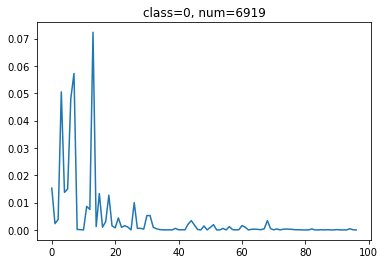

0 POST /.../getDept.do 0.0152620935391
3 POST common/.../chooseHospital.do 0.0504910862967
4 GET common/.../scheduleByDept.do 0.0137220490162
5 POST /.../scheduleByDept.do 0.0149980385275
6 GET common/.../chooseExpert.do 0.0481630293395
7 GET common/.../deptList.do 0.0572337042925
13 GET common/.../notice.do 0.0723099436335
15 GET common/.../expertNotice.do 0.0133063544828
18 POST common/.../deptList.do 0.0126886982871


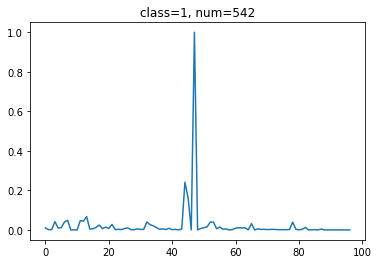

44 GET common/.../reserveList.do 0.241328413284
45 POST /.../getReserveList.do 0.162822878229
47 GET /.../reserveDetail.do 1.0


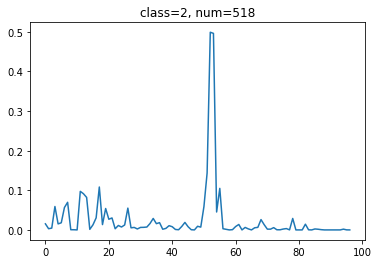

11 GET common/.../reserveConfirm.do 0.0973696911197
12 POST /.../reserveConfirm.do 0.0913432229222
13 GET common/.../notice.do 0.0820463320463
17 GET common/.../patientList.do 0.108301158301
51 GET common/.../addPatient.do 0.143684500827
52 GET /.../amazeui.switch.css 0.499034749035
53 GET /.../ui-anim_basic_16x16.gif 0.496138996139
55 GET /.../arrangementList.do 0.104890604891


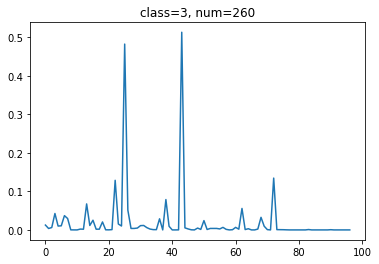

13 GET common/.../notice.do 0.0675480769231
22 GET /.../welcome.html 0.128846153846
25 GET /.../noticePage.html 0.482692307692
38 GET /.../eastFloor.html 0.0788461538462
43 GET /.../appointGuide.html 0.513461538462
72 GET /.../cnterFloor.html 0.134615384615


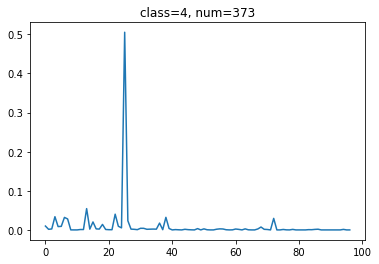

3 POST common/.../chooseHospital.do 0.0338034735983
6 GET common/.../chooseExpert.do 0.0319571045576
13 GET common/.../notice.do 0.0544571045576
22 GET /.../welcome.html 0.0402144772118
25 GET /.../noticePage.html 0.505361930295
38 GET /.../eastFloor.html 0.0321715817694


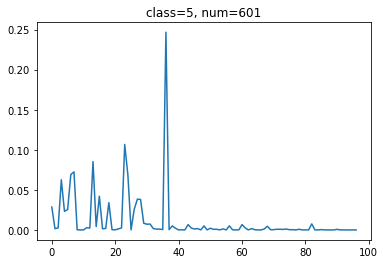

3 POST common/.../chooseHospital.do 0.0625768646459
6 GET common/.../chooseExpert.do 0.0692179700499
7 GET common/.../deptList.do 0.0724283057649
13 GET common/.../notice.do 0.0852745424293
15 GET common/.../expertNotice.do 0.0420410427066
18 POST common/.../deptList.do 0.0340237535143
23 GET common/.../specialClinic.do 0.106655574043
24 POST /.../getDepts.do 0.0685699273141
27 GET common/.../specialSchedule.do 0.0384082085413
28 POST /.../specialSchedule.do 0.0379922351636
36 GET /.../logo.png 0.246672212978


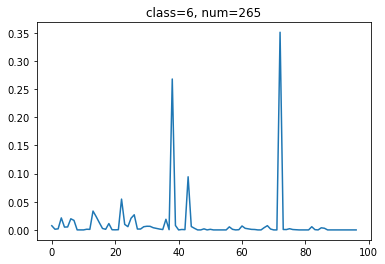

22 GET /.../welcome.html 0.0547169811321
38 GET /.../eastFloor.html 0.267924528302
43 GET /.../appointGuide.html 0.0943396226415
72 GET /.../cnterFloor.html 0.350943396226


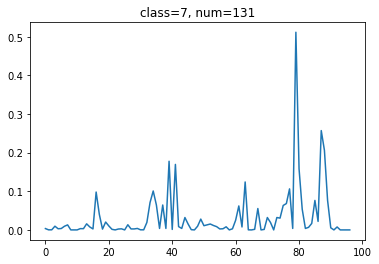

16 GET /.../patientinfo.do 0.0980054173849
34 GET common/.../editPatient.do 0.100763358779
39 GET fee/.../init.do 0.177654406662
41 GET common/.../index.do 0.169465648855
63 GET common/.../bind.do 0.124045801527
77 GET fee/.../patientBalance.do 0.106176266482
79 GET common/.../outpFeeList.do 0.511450381679
80 POST fee/.../feeList.do 0.158015267176
87 GET common/.../balance.do 0.256997455471
88 GET common/.../outFee.do 0.206106870229


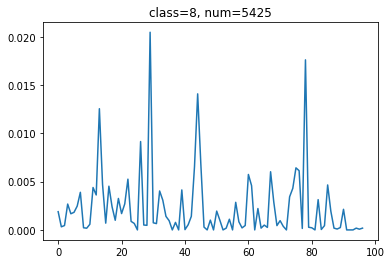

13 GET common/.../notice.do 0.0125460829493
26 GET common/.../login.do 0.00914746543779
29 GET  0.0204608294931
44 GET common/.../reserveList.do 0.0140829493088
78 GET /.../ 0.0176036866359


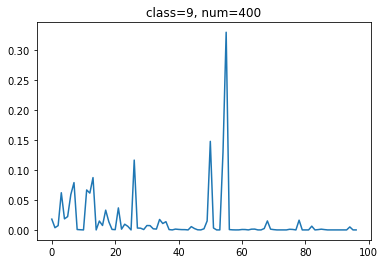

3 POST common/.../chooseHospital.do 0.0620652173913
6 GET common/.../chooseExpert.do 0.059
7 GET common/.../deptList.do 0.0789705882353
11 GET common/.../reserveConfirm.do 0.06671875
12 POST /.../reserveConfirm.do 0.0614473684211
13 GET common/.../notice.do 0.08734375
26 GET common/.../login.do 0.1165625
50 GET patientinfo/.../getVerifyCode.do 0.147857142857
54 GET patientinfo/.../login.do 0.129444444444
55 GET /.../arrangementList.do 0.33


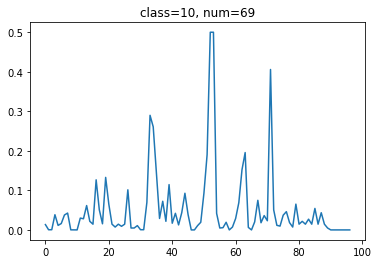

33 GET common/.../patientMgr.do 0.289855072464
34 GET common/.../editPatient.do 0.260869565217
51 GET common/.../addPatient.do 0.190476190476
52 GET /.../amazeui.switch.css 0.5
53 GET /.../ui-anim_basic_16x16.gif 0.5
63 GET common/.../bind.do 0.195652173913
71 GET /.../patientMgr.do 0.405797101449


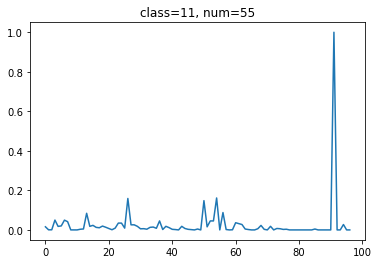

13 GET common/.../notice.do 0.0840909090909
26 GET common/.../login.do 0.159090909091
50 GET patientinfo/.../getVerifyCode.do 0.148051948052
54 GET patientinfo/.../login.do 0.161616161616
56 GET common/.../guide.do 0.0878787878788
91 GET /.../guide.do 1.0


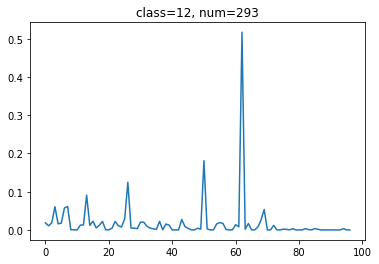

3 POST common/.../chooseHospital.do 0.0606914972548
6 GET common/.../chooseExpert.do 0.0574744027304
7 GET common/.../deptList.do 0.0612326842
13 GET common/.../notice.do 0.0908703071672
26 GET common/.../login.do 0.12457337884
50 GET patientinfo/.../getVerifyCode.do 0.180887372014
62 GET common/.../register.do 0.517064846416


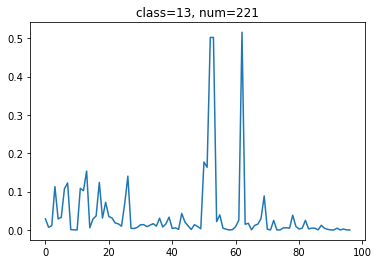

13 GET common/.../notice.do 0.153563348416
26 GET common/.../login.do 0.140271493213
50 GET patientinfo/.../getVerifyCode.do 0.177117000646
51 GET common/.../addPatient.do 0.163542340013
52 GET /.../amazeui.switch.css 0.502262443439
53 GET /.../ui-anim_basic_16x16.gif 0.502262443439
62 GET common/.../register.do 0.515837104072


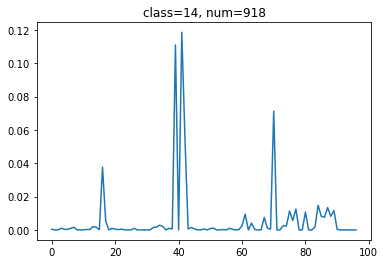

16 GET /.../patientinfo.do 0.037669548106
39 GET fee/.../init.do 0.1110120816
41 GET common/.../index.do 0.11862745098
42 POST fee/.../inFeeList.do 0.0552151416122
70 POST /.../inBalance.do 0.0712418300654


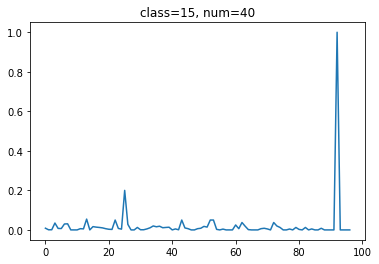

25 GET /.../noticePage.html 0.2
92 GET /.../favicon.ico 1.0


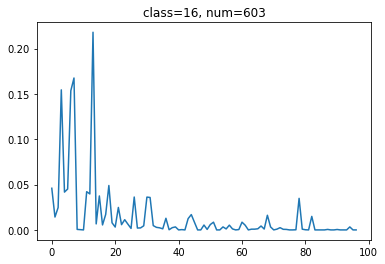

0 POST /.../getDept.do 0.045951345634
3 POST common/.../chooseHospital.do 0.154517268729
5 POST /.../scheduleByDept.do 0.0451077943615
6 GET common/.../chooseExpert.do 0.153565505804
7 GET common/.../deptList.do 0.167593405521
13 GET common/.../notice.do 0.21807628524
18 POST common/.../deptList.do 0.0490078343913


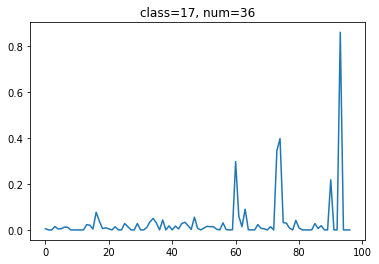

60 GET queue/.../init.do 0.297619047619
73 GET common/.../reserveQueueList.do 0.344444444444
74 POST /.../getQueueList.do 0.398148148148
90 POST queue/.../getQueueDetail.do 0.218253968254
93 GET /.../queueDetail.do 0.861111111111


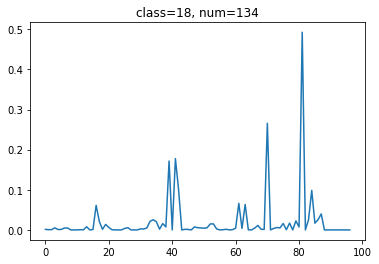

16 GET /.../patientinfo.do 0.0612662493982
39 GET fee/.../init.do 0.171641791045
41 GET common/.../index.do 0.177611940299
42 POST fee/.../inFeeList.do 0.100746268657
61 GET /.../mobiscroll.min.css 0.0662313432836
63 GET common/.../bind.do 0.0634328358209
70 POST /.../inBalance.do 0.265671641791
81 GET common/.../hosBalance.do 0.492537313433
84 GET common/.../inFee.do 0.0985074626866


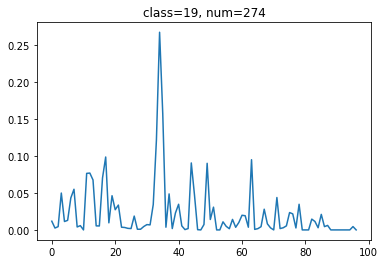

11 GET common/.../reserveConfirm.do 0.0764142335766
12 POST /.../reserveConfirm.do 0.076834421821
13 GET common/.../notice.do 0.0675182481752
16 GET /.../patientinfo.do 0.0702849069932
17 GET common/.../patientList.do 0.0985401459854
33 GET common/.../patientMgr.do 0.121480709072
34 GET common/.../editPatient.do 0.267153284672
35 POST patientinfo/.../getPatientInfoById.do 0.156934306569
44 GET common/.../reserveList.do 0.0905109489051
49 POST /.../setDefault.do 0.0900243309002
63 GET common/.../bind.do 0.0948905109489


In [159]:
for x in range(0,n_clusters):
    plt.title(''.join(['class=',str(x),', num=',str((labels==x).sum())]))
    plt.plot(kmeans.cluster_centers_[x])
    plt.show()  
    feature_avg = kmeans.cluster_centers_[x].mean()
    for idx, feature in enumerate(kmeans.cluster_centers_[x]):
        if feature > feature_avg*3:
            print(idx, unique_url_list[idx], feature)


In [180]:
for i in range(len(labels)):
    if labels[i] == 0:
        if len(all_op_matrix_op_list[i]['urls']) > 50:
            print (i,end=', ')

21, 1426, 1630, 2073, 2623, 2663, 3962, 4666, 8779, 8952, 9210, 9449, 9918, 10926, 12339, 12966, 13720, 16044, 16082, 16230, 16444, 16769, 16920, 17540, 17921, 17940, 18060, 18074, 

In [181]:
samples = [16444, 16769, 16920, 17540, 17921, 17940, 18060, 18074]
for x in samples:
    print (all_op_matrix_op_list[x],end='\n\n')

{'start_time': '2017-07-13 22:40:20', 'end_time': '2017-07-14 00:00:06', 'urls': ['POST /.../getAccountInfo.do', 'GET /.../patientinfo.do', 'GET /.../patientinfo.do', 'GET /.../patientinfo.do', 'GET /.../patientinfo.do', 'POST /.../getAccountInfo.do', 'GET common/.../scheduleByDept.do', 'POST /.../scheduleByDept.do', 'POST common/.../chooseHospital.do', 'POST common/.../chooseExpert.do', 'GET common/.../deptList.do', 'POST /.../getDept.do', 'GET common/.../arrangementList.do', 'POST /.../getTimeList.do', 'POST /.../getAccountInfo.do', 'POST /.../getTimeList.do', 'GET /.../patientinfo.do', 'POST /.../getTimeList.do', 'GET /.../patientinfo.do', 'GET /.../patientinfo.do', 'POST /.../getTimeList.do', 'GET /.../patientinfo.do', 'POST /.../getTimeList.do', 'POST common/.../chooseHospital.do', 'POST common/.../chooseExpert.do', 'GET common/.../deptList.do', 'POST /.../getDept.do', 'GET common/.../scheduleByDept.do', 'POST /.../scheduleByDept.do', 'GET common/.../arrangementList.do', 'POST /..

In [58]:
for i in all_op_matrix_list:
    if i[-4]>=1:
        print (i)
# scaler.transform(all_op_matrix_list[9163])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]


In [56]:
all_op_matrix_list[9163][-4]

1

In [30]:
#校验一下数据化的对不对
values = list(url_visit_dict.values())
urls = list(url_visit_dict.keys())
values[2]
urls[2]

NameError: name 'url_visit_dict' is not defined

In [ ]:
url_visit_dict['GET common/.../deptList.do']

In [ ]:
for ip in attribute_dict:
    if attribute_dict[ip]['coverage'] > 0.5:
        print(ip)